In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from matplotlib import cm
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

### The matrix completion problem
Next, we will look at another commonly used non-differentiable regularization term using the matrix completion problem. The basic idea is that we have a matrix (known to be low-rank) which has some missing entries. Let $Y\in\mathbb{R}^{m\times n}$ be the matrix, $(i,j)\in \Omega$ the entries that we have observed, and $B$ our estimate of the full matrix. We construct an objective function ($\mathcal{E}$) by quantifying the squared error of our estimated matrix $B$ and by penalizing high rank solutions using a regularization term:
$$
\mathcal{E}(B):=\frac{1}{2} \sum_{(i,j)\in\Omega} (Y_{ij}-B_{ij})^2 + \lambda||B||_{tr}.
$$
where $\lambda||B||_{tr}$ refers to the nuclear norm of $B$ which is the sum of its singular values.

For clarity of notation, let $P_\Omega$ be the projection operator onto the set $\Omega$, defined as:
$$
[P_\Omega(B)]_{ij}:=\begin{cases} B_{ij} &\mbox{if } (i,j)\in\Omega, \\
0&\mbox{otherwise}. 
\end{cases}
$$
Then we can then simplify our objective function by rewriting it as:
\begin{align*}
 \mathcal{E}(B) &= g(B) + h(B), \\
 g(B) &= \frac{1}{2} || P_\Omega(Y)-P_\Omega(B)||^2_F, \\
 h(B) &= \lambda||B||_{tr},
\end{align*}
where $||\ \cdot\ ||_F$ is the Frobenius norm. We thus have a definition suitable for the proximal gradient method. That is, we have an objective function $\mathcal{E}$ consisting of a sum of two convex functions $g$ and $h$, where only $g$ is smooth. Thus, the problem that remains is to compute the gradient of $g$ and the proximity operator for $h$. Rather straightforwardly, we obtain the gradient as:
$$
\nabla g(B)=-(P_\Omega(Y)-P_\Omega(B)),
$$
since
$$
(\nabla g(B))_{kl}=\frac{\partial}{\partial B_{kl}} \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m (P_\Omega(Y)_{ij}-P_\Omega(B)_{kl})^2=\frac{1}{2} \frac{\partial}{\partial B_{kl}} (P_\Omega(Y)_{kl}-P_\Omega(B)_{kl})^2=-(P_\Omega(Y)-P_\Omega(B))_{kl}.
$$
The proximity operator for $h$ is slightly trickier to solve, but the end result is that
$$
\operatorname{prox}_{\eta}(B)=S_{\eta \lambda}(B)
$$
where $S_{\eta \lambda}$ is the matrix soft-thresholding operator. (DERIVATION MISSING STILL!!!.) Let now $B=U\Sigma V^T$ be the Singular Value Decomposition (SVD) of $B$ and $\Sigma_{\eta \lambda}$ a diagonal matrix such that $(\Sigma_{\eta \lambda})_{ii}=\operatorname{max}\{\Sigma_{ii}-\eta \lambda,0\}$. Then, the matrix soft-thresholding operator is defined as
$$
S_{\eta \lambda}:=U\Sigma_{\eta \lambda} V^T.
$$
That is, the matrix soft-thresholding operator penalizes non-zero singular values and sets them to zero whenever they decrease below $\eta \lambda$. A higher value of $\lambda$ will thus cause more singular values to be zero, and consequently cause $B$ to be of lower-rank.

In [3]:
def gFun(B, Y, Omega):
    return (np.sum((B[Omega]-Y[Omega])**2))/2

def hFun(B, regLambda):
    U, Sigma, VT = np.linalg.svd(B, full_matrices=False)
    return regLambda*np.linalg.norm(Sigma, 1)

def objFun(B, Y, Omega, regLambda):
    return gFun(B, Y, Omega) + hFun(B, regLambda)

def gFunDer(B, Y, Omega):
    negGrad = np.zeros(B.shape)
    negGrad[Omega] = -Y[Omega] + B[Omega]
    return negGrad

def matrixSoftThresholdingFun(B, th):
    U, Sigma, VT = np.linalg.svd(B, full_matrices=False)
    Sigma = Sigma - th
    Sigma[Sigma<0] = 0
    return np.dot(U * Sigma, VT)

### Matrix completion example

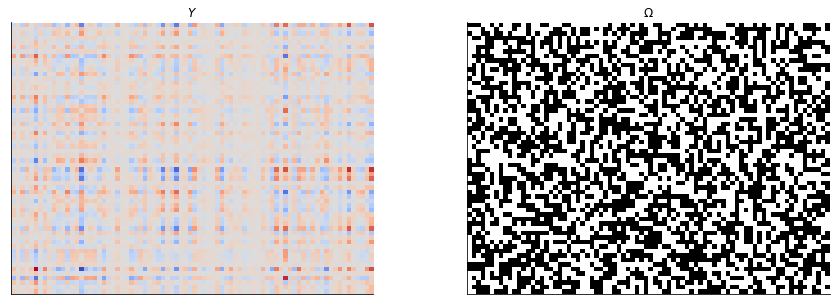

In [30]:
m = 60        # Rows of Y
n = 80        # Columns of Y
k = 2         # N outer products
nZeros = int(0.5*m*n)  # N missing elements in Y

# Create a random full Y matrix
W1 = np.random.randn(m, k)
W2 = np.random.randn(k, n)
Y = np.matmul(W1, W2)

# Obtain omega by randomly selecting elements to exlude from Y
randPerm = np.random.permutation(m*n)
Omega = np.ones(m*n, dtype=bool)
Omega[randPerm[:nZeros]] = False
Omega = np.reshape(Omega, [m, n])

# Plotting
fig = plt.figure(figsize=(15, 5))
# Y
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Y, cmap=cm.coolwarm)
ax.set_title('$Y$');
ax.set_xticks([])
ax.set_yticks([])
# Omega
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Omega, cmap=cm.gray)
ax.set_title('$\Omega$');
ax.set_xticks([])
ax.set_yticks([]);

### Predict the missing entries using the proximal gradient method

Rank(B): 2


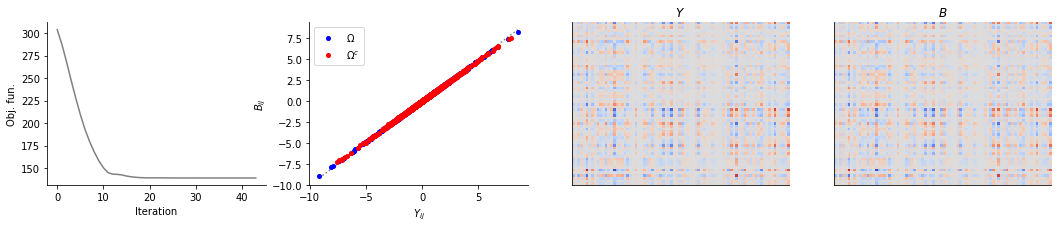

In [33]:
# Proximal gradient parameters
i = 2
eta = 1
beta = 0.8
regLambda = 1
epsilon = 1e-5

# Pre-allocation of memory for algorithm variables
BNew = np.zeros((m, n))
BOld = np.zeros((m, n))
BTmp = np.zeros((m, n))

# Initialization
objFunVals = []
objFunVals.append(objFun(BNew, Y, Omega, regLambda))

# Proximal gradient with backtracking and accerlation
converged = False
while not converged:
    gradTmp = gFunDer(BTmp, Y, Omega)
    gTmp = gFun(BTmp, Y, Omega)
    # Backtracking loop
    while True:
        BNew = matrixSoftThresholdingFun(BTmp - eta*gradTmp, eta*regLambda)
        diff = BNew - BTmp
        if gFun(BNew, Y, Omega) > gTmp + np.sum(np.multiply(gradTmp, diff)) + np.sum(diff**2)/(2*eta):
            eta *= beta
        else:
            break
    objFunVals.append(objFun(BNew, Y, Omega, regLambda))
    BTmp = BNew + (i-2)/(i-1)*(BNew-BOld)  # Acceleration
    BOld = BNew
    i += 1
    
    # Converge check, mean over previous 10 iterations due to Nesterow ripples with acceleration
    if len(objFunVals) > 12: 
        if (np.mean(objFunVals[-12:-2]) - objFunVals[-1]) / objFunVals[-1] < epsilon: 
            converged = True 
            
objFunVals = np.array(objFunVals)
U, Sigma, VT = np.linalg.svd(BNew, full_matrices=False)
print('Rank(B):', np.sum(Sigma > 1e-10))

# Plotting
fig = plt.figure(figsize=(18, 3))
# Objective function
ax = fig.add_subplot(1, 4, 1)
ax.plot(range(objFunVals.size-1), objFunVals[1:], c=[0.5, 0.5, 0.5])
ax.set_xlabel('Iteration')
ax.set_ylabel('Obj. fun.')
# Estimated and real element values
ax = fig.add_subplot(1, 4, 2)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k:', color=[0.5, 0.5, 0.5])
ph1, = ax.plot(Y[Omega].ravel(), BNew[Omega].ravel(), 'b.', ms=8, label='$\Omega$')
ph2, = ax.plot(Y[~Omega].ravel(), BNew[~Omega].ravel(), 'r.', ms=8, label='$\Omega^c$')
ax.legend(handles=[ph1, ph2])
ax.set_ylabel('$B_{ij}$')
ax.set_xlabel('$Y_{ij}$')
# Y
ax = fig.add_subplot(1, 4, 3)
ax.imshow(Y, cmap=cm.coolwarm, clim=[-np.max(np.abs(Y)), np.max(np.abs(Y))])
ax.set_title('$Y$');
ax.set_xticks([])
ax.set_yticks([])
# B
ax = fig.add_subplot(1, 4, 4)
ax.imshow(BNew, cmap=cm.coolwarm, clim=[-np.max(np.abs(BNew)), np.max(np.abs(BNew))])
ax.set_title('$B$');
ax.set_xticks([])
ax.set_yticks([]);


### Comparing the original and found vectors

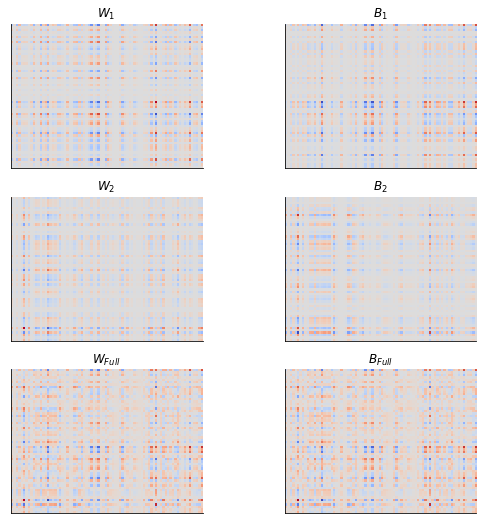

In [35]:
# Plotting
fig = plt.figure(figsize=(9, 3*(k+1)))

for kIdx in range(k):
    # W part
    ax = fig.add_subplot(k+1, 2, kIdx*2+1)
    WTmp = np.outer(W1[:,kIdx], W2[kIdx, :])
    ax.imshow(WTmp, cmap=cm.coolwarm, clim=[-np.max(np.abs(WTmp)), np.max(np.abs(WTmp))])
    ax.set_title('$W_{:1d}$'.format(kIdx+1));
    ax.set_xticks([])
    ax.set_yticks([]);
    # B part
    ax = fig.add_subplot(k+1, 2, kIdx*2+2)
    BTmp = np.outer(U[:,kIdx], VT[kIdx, :])
    ax.imshow(BTmp, cmap=cm.coolwarm, clim=[-np.max(np.abs(BTmp)), np.max(np.abs(BTmp))])
    ax.set_title('$B_{:1d}$'.format(kIdx+1));
    ax.set_xticks([])
    ax.set_yticks([]);

# W full
ax = fig.add_subplot(k+1, 2, kIdx*2+3)
WTmp = np.matmul(W1, W2)
ax.imshow(WTmp, cmap=cm.coolwarm)
ax.set_title('$W_{Full}$');
ax.set_xticks([])
ax.set_yticks([]);
# B full
ax = fig.add_subplot(k+1, 2, kIdx*2+4)
BTmp = np.matmul(U*Sigma, VT)
ax.imshow(BTmp, cmap=cm.coolwarm, )
ax.set_title('$B_{Full}$');
ax.set_xticks([])
ax.set_yticks([]);